In [0]:
# https://keras.io/
!pip install -q keras
import keras
from keras import utils as np_utils
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, SeparableConv2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.merge import concatenate

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k


# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


#### EXPLANATION

-  We are looping through class by class and taking the index of one specific class in loop.
-  Taking all those indexes training features and as features_idx.
-  Picking random number and displaying that image and setting title.

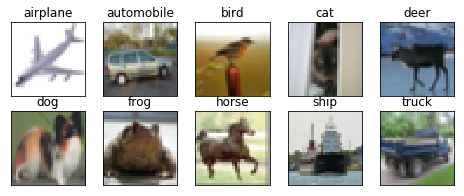

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

#### EXPLANATION

-  It predicts test results and take the maximum index value and so it means model predicted that index category.
-  Equate the results, sum it, divide and print the accuracy.

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#### EXPLANATION
-  It usually reduce the resolution by half and increases the channels by four times, used while concatenate.

In [0]:
# Reduce dimensions to half
def space_to_depth_x1(x):
    return tf.space_to_depth(x, block_size=2)

In [0]:
# Reduce dimensions to quarter
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=4)

#### EXPLANATION
-  Gave a proper go through of all the connections from the architecture diagram and added.
-  Understood how to reduce dimensions, add it.

In [0]:
#Input
input = Input(shape=(img_rows,img_cols,img_channels,))

#Reducing dimensions to half = To concatenate to any other layer after first max pool.
#Reducing dimensions to quarter = To concatenate to any other layer after second max pool.

#Layer1 + Layer1_Half_Dimension + Layer1_Quarter_Dimension
layer1 = SeparableConv2D(32,(5,5),strides=(1,1),name='conv_1',border_mode='same',use_bias=False)(input)
layer1 = BatchNormalization()(layer1)
layer1 = Activation('relu')(layer1)
layer1skip = layer1
layer1half = Lambda(space_to_depth_x1)(layer1skip)
layer1quarter = Lambda(space_to_depth_x2)(layer1skip)

#Layer2 + Layer2_Half_Dimension + Layer2_Quarter_Dimension
layer2 = Conv2D(64,(5,5), strides=(1,1),name='conv_2',border_mode='same', use_bias=False)(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = Activation('relu')(layer2)
layer2skip = layer2
layer2half = Lambda(space_to_depth_x1)(layer2skip)
layer2quarter = Lambda(space_to_depth_x2)(layer2skip)

#Layer3 + Layer3_Half_Dimension + Layer3_Quarter_Dimension
layer3 = Conv2D(64,(5,5), strides=(1,1),name='conv_3',border_mode='same', use_bias=False)(layer2)
layer3 = BatchNormalization()(layer3)
layer3 = Activation('relu')(layer3)
layer3skip = layer3
layer3half = Lambda(space_to_depth_x1)(layer3skip)
layer3quarter = Lambda(space_to_depth_x2)(layer3skip)

Confirst = concatenate([layer1,layer3])

#Layer4 + Layer4_Half_Dimension + Layer4_Quarter_Dimension
layer4 = SeparableConv2D(128,(5,5),strides=(1,1),name='conv_4',border_mode='same',use_bias=False)(Confirst)
layer4 = BatchNormalization()(layer4)
layer4 = Activation('relu')(layer4)
layer4skip = layer4
layer4half = Lambda(space_to_depth_x1)(layer4skip)
layer4quarter = Lambda(space_to_depth_x2)(layer4skip)

Consecond = concatenate([layer1,layer4])

Maxpool1 = MaxPooling2D(pool_size=(2, 2))(Consecond)
Just1x1 = Conv2D(32,(1,1), strides=(1,1),name='first1x1',border_mode='same', use_bias=False)(Maxpool1)
Maxpool1skip = Just1x1

#Layer5 + Layer5_Half_Dimension + Layer5_Quarter_Dimension
layer5 = SeparableConv2D(64,(3,3),strides=(1,1),name='conv_5',border_mode='same',use_bias=False)(Just1x1)
layer5 = BatchNormalization()(layer5)
layer5 = Activation('relu')(layer5)
layer5skip = layer5
layer5half = Lambda(space_to_depth_x1)(layer5skip)

Conthird = concatenate([layer5,layer1half,layer2half])

#Layer6 + Layer6_Half_Dimension + Layer6_Quarter_Dimension
layer6 = Conv2D(128,(5,5), strides=(1,1),name='conv_6',border_mode='same', use_bias=False)(Conthird)
layer6 = BatchNormalization()(layer6)
layer6 = Activation('relu')(layer6)
layer6skip = layer6
layer6half = Lambda(space_to_depth_x1)(layer6skip)

Confourth = concatenate([layer5,layer3half,layer1half,layer6])

#Layer7 + Layer7_Half_Dimension + Layer7_Quarter_Dimension
layer7 = SeparableConv2D(128,(3,3),strides=(1,1),name='conv_7',border_mode='same',use_bias=False)(Confourth)
layer7 = BatchNormalization()(layer7)
layer7 = Activation('relu')(layer7)
layer7skip = layer7
layer7half = Lambda(space_to_depth_x1)(layer7skip)

Confifth = concatenate([layer1half,layer3half,layer4half,layer5,layer6,layer7])

#Layer8 + Layer8_Half_Dimension + Layer8_Quarter_Dimension
layer8 = SeparableConv2D(128,(5,5),strides=(1,1),name='conv_8',border_mode='same',use_bias=False)(Confifth)
layer8 = BatchNormalization()(layer8)
layer8 = Activation('relu')(layer8)
layer8skip = layer8
layer8half = Lambda(space_to_depth_x1)(layer8skip)

Consixth = concatenate([layer1half,layer4half,layer5,layer8,layer7])

Maxpool2 = MaxPooling2D(pool_size=(2, 2))(Consixth)
Second1x1 = Conv2D(32,(1,1), strides=(1,1),name='second1x1',border_mode='same', use_bias=False)(Maxpool2)
Maxpool2skip = Second1x1

Conseventh = concatenate([layer6half,Second1x1])

#Layer9 + Layer9_Half_Dimension + Layer9_Quarter_Dimension
layer9 = Conv2D(64,(5,5), strides=(1,1),name='conv_9',border_mode='same', use_bias=False)(Conseventh)
layer9 = BatchNormalization()(layer9)
layer9 = Activation('relu')(layer9)
layer9skip = layer9

Coneighth = concatenate([layer1quarter,layer2quarter,layer7half,layer9])

#Layer10 + Layer10_Half_Dimension + Layer10_Quarter_Dimension
layer10 = SeparableConv2D(128,(5,5),strides=(1,1),name='conv_10',border_mode='same',use_bias=False)(Coneighth)
layer10 = BatchNormalization()(layer10)
layer10 = Activation('relu')(layer10)
layer10skip = layer10

Conninth = concatenate([layer3quarter,layer2quarter,layer5half,layer9,layer10])

#Layer11 + Layer11_Half_Dimension + Layer11_Quarter_Dimension
layer11 = Conv2D(128,(3,3), strides=(1,1),name='conv_11',border_mode='same', use_bias=False)(Conninth)
layer11 = BatchNormalization()(layer11)
layer11 = Activation('relu')(layer11)
layer11skip = layer11

Contenth = concatenate([layer3quarter,layer1quarter,layer4quarter,layer5half,layer7half,layer10,layer11])

#Layer12 + Layer12_Half_Dimension + Layer12_Quarter_Dimension
layer12 = SeparableConv2D(128,(5,5),strides=(1,1),name='conv_12',border_mode='same',use_bias=False)(Contenth)
layer12 = BatchNormalization()(layer12)
layer12 = Activation('relu')(layer12)
layer12skip = layer12

Coneleventh = concatenate([layer4quarter,layer7half,layer12,layer11])

#Layer13
Third1x1 = Conv2D(10,(1,1), strides=(1,1),name='third1x1',border_mode='same', use_bias=False)(Coneleventh)
layer13 = Conv2D(10,(8,8),strides=(1,1),name='conv_13',use_bias=False)(Third1x1)
layer14 = Flatten()(layer13)

output = Activation('softmax')(layer14)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), strides=(1, 1), name="conv_1", use_bias=False, padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), strides=(1, 1), name="conv_2", use_bias=False, padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), strides=(1, 1), name="conv_3", use_bias=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (5, 5), strides=(1, 1), name="conv_4", use_bias=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: 

In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (SeparableConv2D)        (None, 32, 32, 32)   171         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 32, 32, 32)   128         conv_1[0][0]                     
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 32, 32, 32)   0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
conv_2 (Co

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0617 14:23:36.899829 140092671059840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
import time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':
W0617 14:23:48.301278 140092671059840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and wil

Epoch 1/100
390/390 [==============================] - 188s 483ms/step - loss: 1.4920 - acc: 0.4681 - val_loss: 1.4868 - val_acc: 0.5057
Epoch 2/100
390/390 [==============================] - 181s 465ms/step - loss: 0.9983 - acc: 0.6499 - val_loss: 1.1388 - val_acc: 0.6143
Epoch 3/100
390/390 [==============================] - 180s 461ms/step - loss: 0.7844 - acc: 0.7272 - val_loss: 0.8424 - val_acc: 0.7092
Epoch 4/100
390/390 [==============================] - 179s 459ms/step - loss: 0.6228 - acc: 0.7822 - val_loss: 0.8213 - val_acc: 0.7180
Epoch 5/100
390/390 [==============================] - 179s 459ms/step - loss: 0.4877 - acc: 0.8299 - val_loss: 1.1226 - val_acc: 0.6471
Epoch 6/100
390/390 [==============================] - 179s 460ms/step - loss: 0.3405 - acc: 0.8817 - val_loss: 0.9511 - val_acc: 0.7191
Epoch 7/100
390/390 [==============================] - 179s 460ms/step - loss: 0.2152 - acc: 0.9265 - val_loss: 1.0078 - val_acc: 0.7183
Epoch 8/100
390/390 [====================

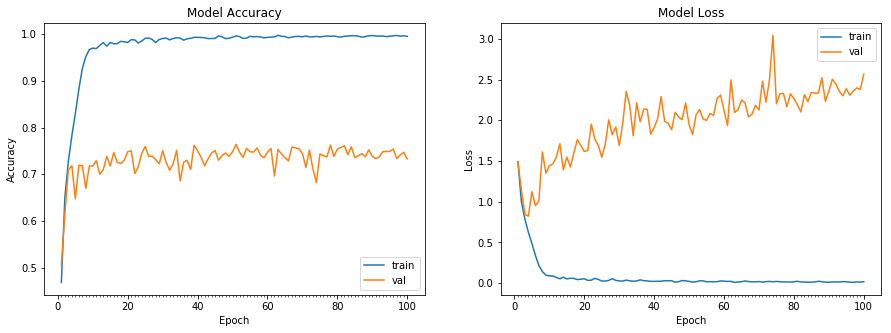

Accuracy on test data is: 73.28


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


#train the model
start = time.time()
#Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))